# Deloitte Analytathon

Importing Packages

In [506]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

from torch.utils.data import DataLoader
from random import shuffle
import matplotlib.image as mpimg
from sklearn.preprocessing import OneHotEncoder

from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from torch.autograd import Variable

import seaborn as sns
sns.set_style("whitegrid")
import librosa
import librosa.display
import csv
import pickle

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

## Checking Dataset - TBC

Check to see the numbers of files in each file directory, can see an even distribution of tracks

In [507]:
categories = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
pathAudio = f"genres/genres_original/"

for i in range(len(categories)):
    file_count = len(os.listdir(str(pathAudio + categories[i])))
    print("categories of " + str(categories[i]) + ": " + str(file_count))

categories of blues: 100
categories of classical: 100
categories of country: 100
categories of disco: 100
categories of hiphop: 100
categories of jazz: 100
categories of metal: 100
categories of pop: 100
categories of reggae: 100
categories of rock: 100


## Creating CSV of Features

create header variable for use in csv creation function

In [508]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

Function to extract popular features for audio classification using Librosa functions:
 - chroma_stft - chroma short-time Fourier transform 
 - rmse - root mean squared energy
 - spec_cent - spectral centroid
 - spec_bw - spectral bandwidth
 - rolloff - spectral rolloff
 - zcr - zero crossing rate
 - mfcc - Mel-frequency cepstral coefficients (20 levels)

In [509]:
def get_features(regrab=False):
    if regrab == True: # to avoid user mistakenly recreating the csv
        file = open('data.csv', 'w', newline='') # open csv (create if it does not exist)
        with file:
            writer = csv.writer(file)
            writer.writerow(header)
        genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()  # list of genres
        # for each file in each genre, grab the data and the sampling rate, use these to retrive features with librosa functions
        for g in genres:
            for filename in os.listdir(f'genres/genres_original/{g}'):
                songname = f'genres/genres_original/{g}/{filename}'
                y, sr = librosa.load(songname, mono=True, duration=30)
                chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
                rmse = librosa.feature.rmse(y=y)
                spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
                spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
                rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
                zcr = librosa.feature.zero_crossing_rate(y)
                mfcc = librosa.feature.mfcc(y=y, sr=sr)
                to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
                for e in mfcc: # 20 mfcc values so add the relevant value to each column
                    to_append += f' {np.mean(e)}'
                to_append += f' {g}'
                file = open('data.csv', 'a', newline='')
                with file:
                    writer = csv.writer(file)
                    writer.writerow(to_append.split()) # add the row to the csv
                    
get_features(regrab=False) # set to False to not remake the csv file

## Creating Mel-Spectograms

Creating train and test folders (if they do not already exist)

In [510]:
if (not os.path.exists('train')) and (not os.path.exists('test')):
    os.mkdir('train')
    os.mkdir('test')
    
    for genre in categories:
        os.mkdir(str('train/') + str(genre))

    for genre in categories:
        os.mkdir(str('test/') + str(genre))


Defining a function to grab the files and input them into the newly created folders  
The function shrinks the image, and ensures consistency across monitors when saving the figure  
It also removes the colourbar and axes, which are unncessary features for the CNN - only the image of the mel-spectogram is required

In [511]:
def grab_files(regrab=False):
    if regrab == True: # to avoid user mistakenly recreating the csv
        pathAudio = f"genres/genres_original/"
        # for each file in each folder, pad and crop each file to be exactly 30 seconds, create a melspectogram
        # save just the *image* (not the graph) to the newly created train and test folders and subfolders
        # this image is smaller and has a set dpi to ensure consistency across monitors, and the speed training of the CNN
        for i in range(len(categories)):
            file_count = len(os.listdir(str(pathAudio + categories[i])))
            for j in range(file_count):
                pathAudio_i = str(pathAudio + categories[i])
                files = librosa.util.find_files(pathAudio_i, ext=['wav']) 
                files = np.asarray(files)
                data, sr = librosa.load(files[j], duration = 30) # cropping audio over 30 seconds, also saving the sample rate
                durations = librosa.get_duration(data, sr=sr)
                if durations < 30: # padding audio less than 30s to 30s with zeroes
                    print("Audio too short at " + str(categories[i] + str(j)))
                    print(durations)
                    data = librosa.util.fix_length(data = data, size = 661500, axis=-1) # 661500 at default sr (sample rate) is 30s
                    durations = librosa.get_duration(data, sr=sr)
                    print("After padding, duration is now", durations) # checking duration is changed to 30s
                S = librosa.feature.melspectrogram(data)
                plt.figure(figsize=(3, 3), dpi=80)
                S_DB = librosa.power_to_db(S, ref=np.max)
                plt.axis('off')
                librosa.display.specshow(S_DB)
                if j < 80:
                    pathImage_i = str("train/" + categories[i] + "/")
                else:
                    pathImage_i = str("test/" + categories[i] + "/")
                plt.savefig(str(pathImage_i) + str(categories[i]) + '_'  + str(j) + '_' + 'spec.png', bbox_inches='tight', pad_inches=0)
grab_files(regrab=False) # set to False to not regrab images

## EDA with CSV

### Initial Inspection

Confirming tidy format

In [512]:
df = pd.read_csv('data.csv')
df.head()

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00000.wav,0.349943,0.130225,1784.420446,2002.650192,3806.485316,0.083066,-113.596742,121.557302,-19.158825,...,8.810668,-3.667367,5.751690,-5.162761,0.750947,-1.691937,-0.409954,-2.300208,1.219928,blues
1,blues.00001.wav,0.340983,0.095918,1529.835316,2038.617579,3548.820207,0.056044,-207.556796,124.006717,8.930562,...,5.376802,-2.239119,4.216963,-6.012273,0.936109,-0.716537,0.293875,-0.287431,0.531573,blues
2,blues.00002.wav,0.363603,0.175573,1552.481958,1747.165985,3040.514948,0.076301,-90.754394,140.459907,-29.109965,...,5.789265,-8.905224,-1.083720,-9.218359,2.455805,-7.726901,-1.815724,-3.433434,-2.226821,blues
3,blues.00003.wav,0.404779,0.141191,1070.119953,1596.333948,2185.028454,0.033309,-199.431144,150.099218,5.647594,...,6.087676,-2.476420,-1.073890,-2.874777,0.780976,-3.316932,0.637981,-0.619690,-3.408233,blues
4,blues.00004.wav,0.308590,0.091563,1835.494603,1748.362448,3580.945013,0.101500,-160.266031,126.198800,-35.605448,...,-2.806385,-6.934122,-7.558619,-9.173552,-4.512166,-5.453538,-0.924162,-4.409333,-11.703781,blues


No missing values, Librosa functions have all returned values

In [513]:
df[df.isna().any(axis=1)]

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label


Checking data types of each variable  
All variables have been read in as the correct datatype

In [514]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 28 columns):
filename              1000 non-null object
chroma_stft           1000 non-null float64
rmse                  1000 non-null float64
spectral_centroid     1000 non-null float64
spectral_bandwidth    1000 non-null float64
rolloff               1000 non-null float64
zero_crossing_rate    1000 non-null float64
mfcc1                 1000 non-null float64
mfcc2                 1000 non-null float64
mfcc3                 1000 non-null float64
mfcc4                 1000 non-null float64
mfcc5                 1000 non-null float64
mfcc6                 1000 non-null float64
mfcc7                 1000 non-null float64
mfcc8                 1000 non-null float64
mfcc9                 1000 non-null float64
mfcc10                1000 non-null float64
mfcc11                1000 non-null float64
mfcc12                1000 non-null float64
mfcc13                1000 non-null float64
mfcc14         

Summary statistics for each variable to see if there are large differences between values such as IQ range, mean and max  

In [515]:
df.describe()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.378669,0.130929,2201.834226,2242.559613,4571.702159,0.103637,-144.479173,99.552199,-8.921949,36.293063,...,-6.021121,4.471604,-4.797232,1.781547,-3.870275,1.147988,-3.967431,0.507303,-2.328779,-1.094875
std,0.081706,0.065685,715.961347,526.337663,1574.770035,0.041834,100.235661,31.331904,21.695015,16.666987,...,6.819018,6.717312,6.170919,5.009489,4.874423,4.579110,4.550650,3.869088,3.755574,3.837561
min,0.171782,0.005276,569.930721,897.994319,749.062137,0.021701,-552.064063,-1.527148,-89.901142,-18.768461,...,-28.052265,-15.805227,-27.542309,-12.598773,-17.545474,-15.693589,-17.227765,-11.975698,-18.504188,-19.935203
25%,0.319641,0.086625,1627.793931,1907.136505,3380.956639,0.070281,-200.695133,76.811480,-24.223791,24.107395,...,-10.966826,-0.551576,-9.363372,-1.640080,-7.164838,-1.857098,-7.194297,-2.003979,-4.670281,-3.368000
50%,0.383075,0.122448,2209.468780,2221.408983,4658.671830,0.099539,-120.206072,98.452551,-10.716073,36.957074,...,-5.920161,3.891842,-4.199810,1.879424,-3.614473,1.211944,-4.059109,0.669788,-2.391261,-1.155198
75%,0.435974,0.175793,2691.969702,2578.474352,5534.197785,0.132007,-73.895019,119.893638,5.505793,48.212826,...,-1.004241,9.706133,-0.161017,5.155264,-0.323536,4.350694,-0.842968,3.112518,0.149070,1.303739
max,0.663573,0.398012,4434.439444,3509.578677,8676.405868,0.274829,42.034587,193.096518,56.666090,80.691273,...,17.421038,23.037571,13.054333,18.161663,12.357588,13.468803,11.489994,15.379257,14.686910,15.368966


### Understanding Variables

A detailed desciption of each audio feature can be found through the following [link](https://towardsdatascience.com/music-genre-classification-with-python-c714d032f0d8)  
The variables can be explored through boxplots, where the differences across genres can be easily visualised  
For instance, the zero crossing rate, which is the rate of sign-changes along a signal, is often reprentative of the level of precussion used in an audio file  
The boxplot below demonstates this, with metal, pop, rock and disco having high zero crossing rates, but jaz and classical having lower zero crossing rates.  
The interquartile ranges is also easily visualised through boxplots, and it can be seen that classical has a relatively small variance in its zero crossing rate, suggesting that most classical songs have similar precussive qualities, while blues has a much higher variance, suggesting that precussion across the genre of blues songs varies much more.  

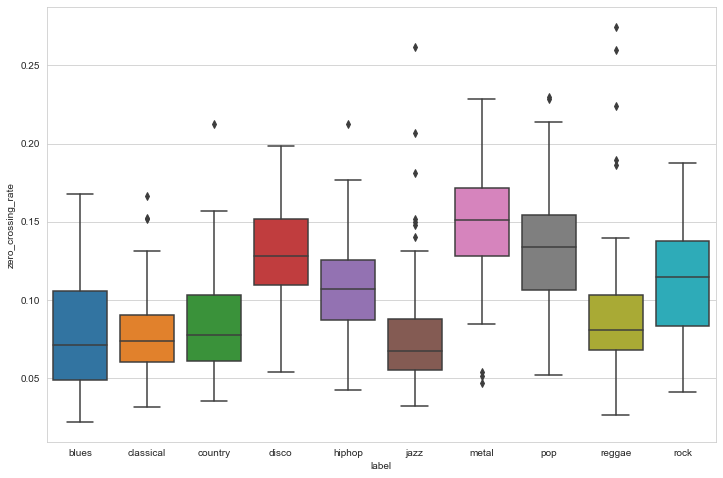

In [516]:
plt.figure(figsize=(12,8))
sns.boxplot(x="label", y="zero_crossing_rate",data=df);

### Cosine Similarity

To better understand the analysis, any results that are obtained from classification, or difficulty that models have in distinguishing certain genres of music, it may be useful to investigate the similarity of genres.  
The cosine similarity is a popular method for determining the similiarity of vectors, more information may be found using the following [link](https://www.machinelearningplus.com/nlp/cosine-similarity/)  

To demonstrate how this function works, it can be seen to return audio files that are have simiilar extracted features.  
After scaling the matrix of numeric features, a function can be defined that return  audio files with the highest cosine similarity to the first file in th

In [517]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
scaled_mat = ss.fit_transform(df.drop(['filename','label'], axis=1))

def get_5_most_similar_songs(input_song):
    names = []
    similarity = []
    song_index = df.index[df['filename']==input_song]
    X = scaled_mat[song_index].reshape(1, -1)
    for i in range(0, len(scaled_mat)):
        Y = scaled_mat[i].reshape(1, -1)
        names.append(df['filename'].iloc[i])
        similarity.append(cosine_similarity(X, Y, dense_output=True)[0])

    similarity_df = pd.DataFrame({"filenames":names, "similarity_to_file_1":similarity})
    return similarity_df.sort_values("similarity_to_file_1", ascending=False)[1:6]

For example, checking hiphop.000008 (Beastie Boys "Slow and Low"), returns the top 5 most similar songs by their cosine similarity, 3 of which are also by the Beastie Boys ("Hey Ladies", "The Negotiation Limerick File" and "Brass Monkey") 

In [518]:
get_5_most_similar_songs('hiphop.00008.wav')

,filenames,similarity_to_file_1
424,hiphop.00024.wav,[0.8474822925150902]
396,disco.00096.wav,[0.8139719176475538]
421,hiphop.00021.wav,[0.7822852932905793]
420,hiphop.00020.wav,[0.7695347109492185]
372,disco.00072.wav,[0.7666162999129784]


To find the similarity between genres, cosine similarity is calculated between genres

In [519]:
summary_df = df.groupby('label').agg('mean')
summary_df.reset_index(level=0, inplace=True)

ss = StandardScaler()
scaled_sumary_mat = ss.fit_transform(summary_df.drop('label', axis=1))


cos_sim_dict = {}
for i in range(len(categories)):
    genre = categories[i]
    genre_index = summary_df.index[summary_df['label']==genre][0]
    cos_sim = []
    for j in range(len(summary_df)):
        cos_sim.append(cosine_similarity(scaled_sumary_mat[genre_index].reshape(1, -1), scaled_sumary_mat[j].reshape(1, -1), dense_output=True)[0][0])
    cos_sim_dict.update( {genre : cos_sim} )

cos_sim_genre_df = pd.DataFrame(cos_sim_dict)
cos_sim_genre_df.index = categories


The values in the dataframe show the similarities between genres

cos_sim_genre_df

The heatmap displays this visually, for example, a high similarity can be seen between classical and jazz (0.801), while a high negative similarity can be seen between disco and classical (-0.699)

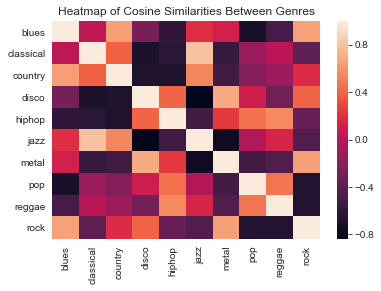

In [520]:
sns.heatmap(cos_sim_genre_df).set_title("Heatmap of Cosine Similarities Between Genres");

### Checking for Data Abnormalities

Histograms can reveal issues with the data such as hard limits on certain variables, extreme values    
An example that aptly demonstrates this is the [cali housing dataset](https://www.kaggle.com/camnugent/california-housing-prices), where house prices are capped at 500,000 usd, and any houses priced over that value are rounded down to 500,001 usd. This is immediately obvious when plotting a histogram, and would obviously have an effect on any models built which involve use of the house price variable.   
These histograms reveal loosely normal distributions for each variable (with some skew such as mfcc1 and zero_crossing_rate), which is reassuring, and indicates that the Librosa functions have not failed in an obvious way, such as by defaulting to a certain value.  
If a linear model were to be used to predict classes, Log transformations of variables could be considered to counteract the skewness that is present in some of the features  

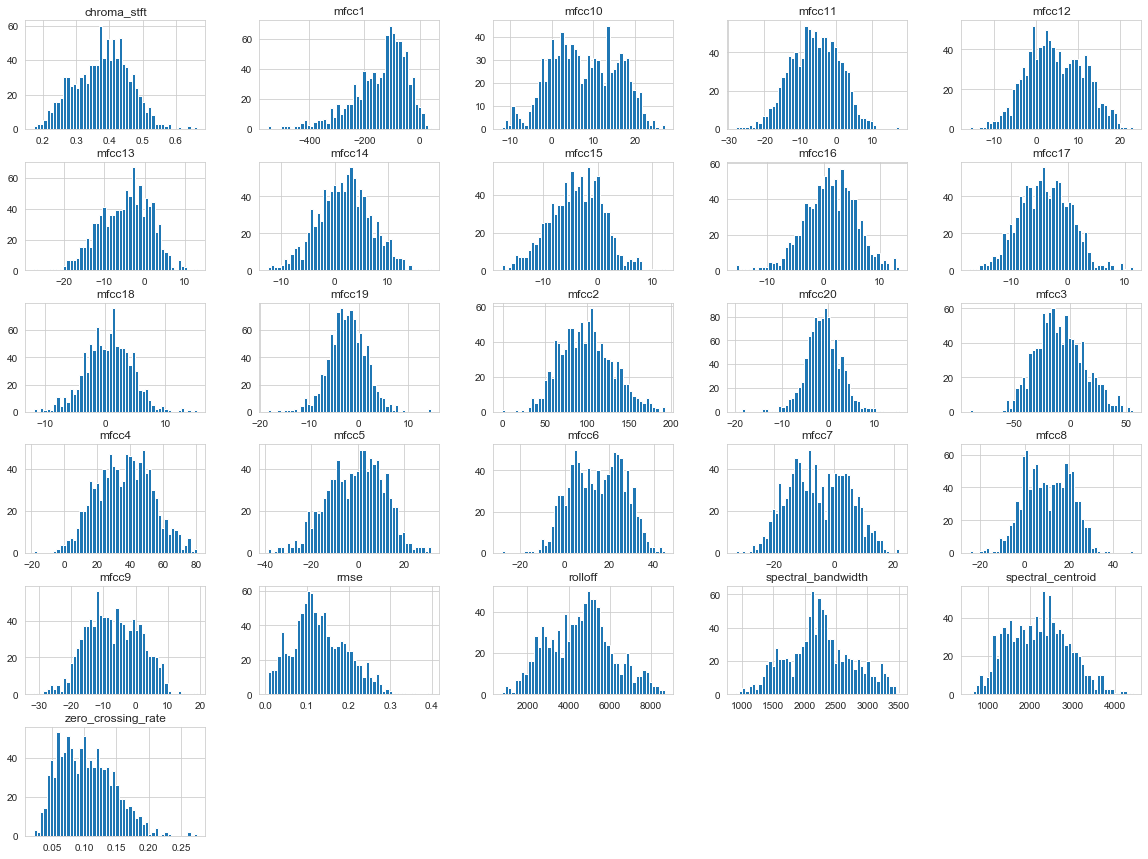

In [525]:
df.hist(bins=50, figsize=(20,15));

### Dealing with Multi-Colinearity

It is also important to deal with the problem of multi-colinearity  
Features that are highly linearly correlated will only serve to add noise to our dataset, and increase the dimensionality of the feature space  


Using a heatmap, a number of variables are seen to are very highly correlated, indicated by the brighter squares in the correlation heatmap, and should be considered for removal  

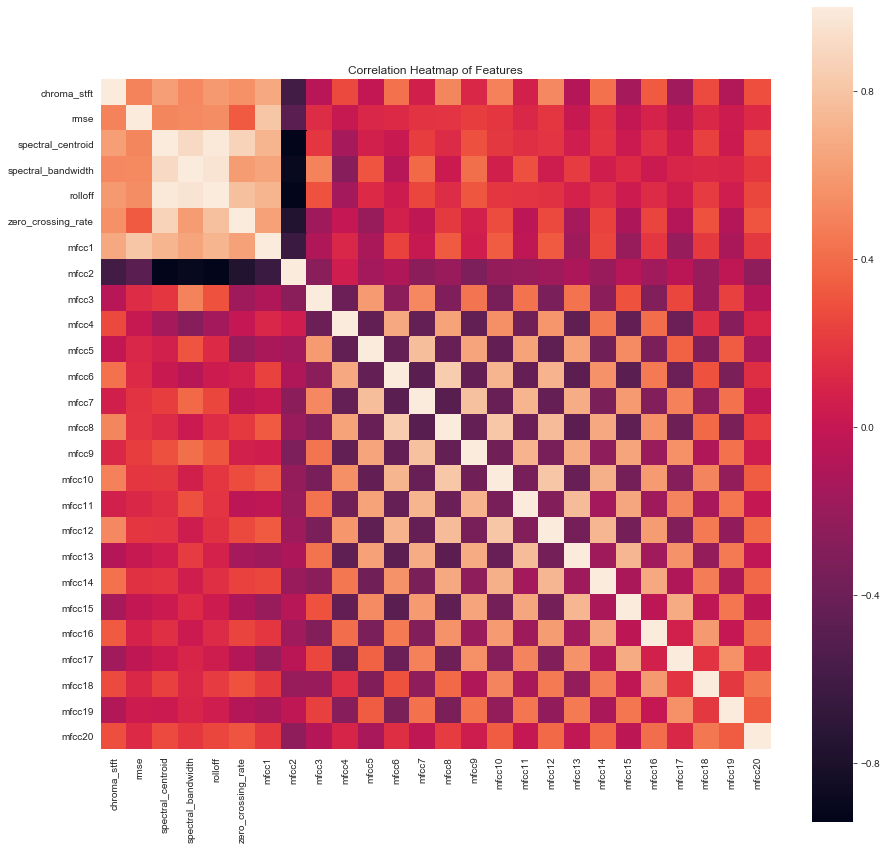

In [503]:
fig = plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), square=True).set_title('Correlation Heatmap of Features');

Inspecting explanatory variables with correlation greater than 0.9  
We can see that Spectral Centroid is strongly correlated with spectral_bandwidth, rolloff and mfcc2  
These are therefore being considered for removal, as long as it is confirmed that these variables are **linearly** correlated

In [248]:
df.corr()[np.abs(df.corr()) > 0.9]

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
chroma_stft,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rmse,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
spectral_centroid,NaN,NaN,1.000000,0.904438,0.979633,NaN,NaN,-0.940171,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
spectral_bandwidth,NaN,NaN,0.904438,1.000000,0.956194,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rolloff,NaN,NaN,0.979633,0.956194,1.000000,NaN,NaN,-0.934305,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zero_crossing_rate,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mfcc1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mfcc2,NaN,NaN,-0.940171,NaN,-0.934305,NaN,NaN,1.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mfcc3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mfcc4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


These correlations can be viewed with a pairplot  
It can be seen that spectral bandwidth and rolloff are linearly correlated, but mfcc2 seems to be slightly non-linear  


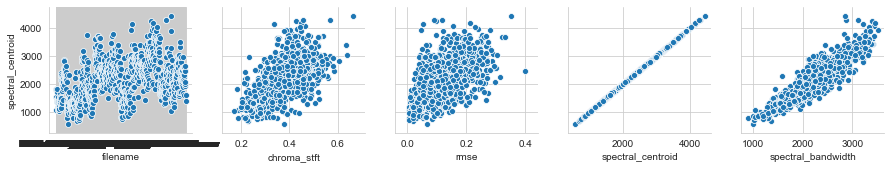

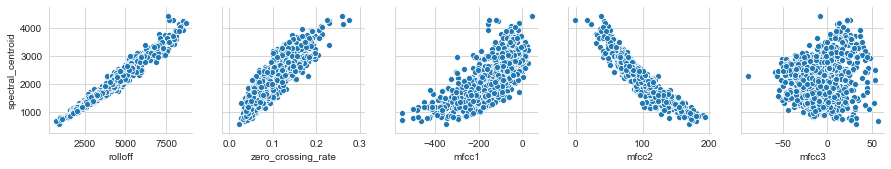

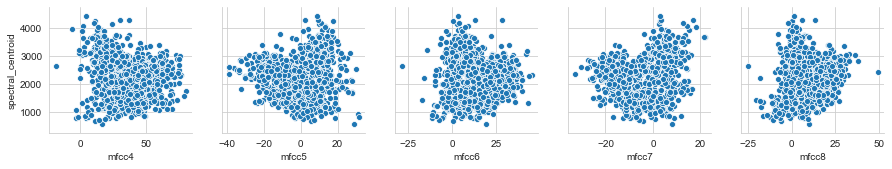

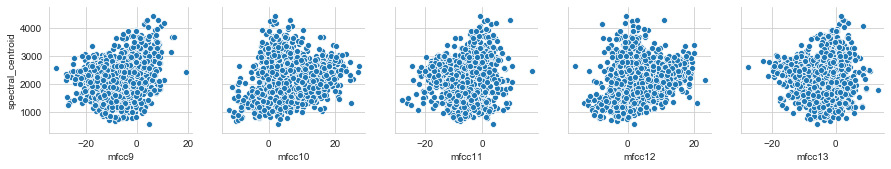

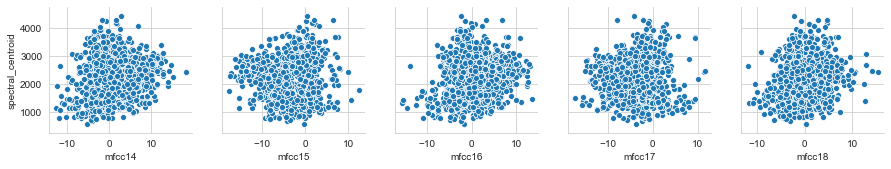

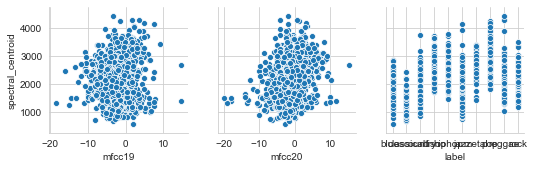

In [249]:
for i in range(0, len(df.columns), 5):
    sns.pairplot(data=df,
                x_vars=df.columns[i:i+5],
                y_vars=['spectral_centroid'])

spectral_bandwidth and rolloff are therefore removed

In [260]:
df_simplified = df.drop(['spectral_bandwidth', 'rolloff'], axis=1)

### Dealing with Outliers

Boxplots can reveal extreme values, and these audio files were inspected individually  
While many outliers were often indicative of an unusual audio file, such as one that was very vocally-centric (disco 47), or those that seem to fit into their own genre, these differences are quite subjective, and there is no objectivity in choosing to remove such outliers

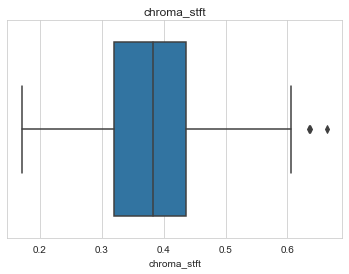

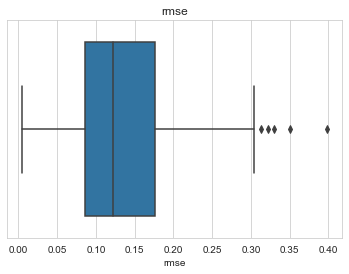

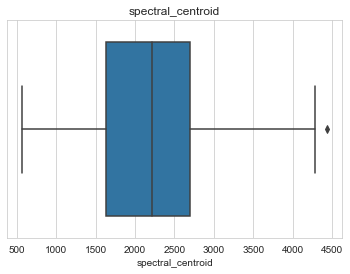

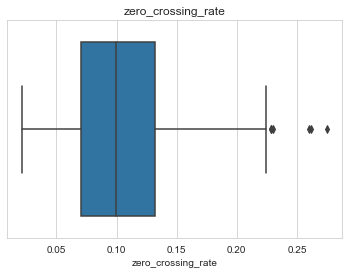

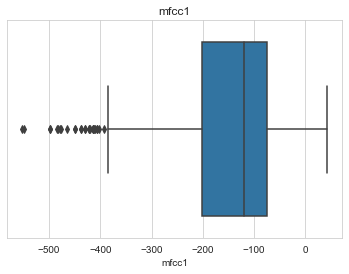

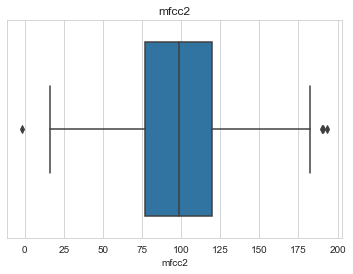

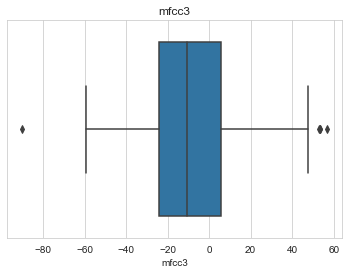

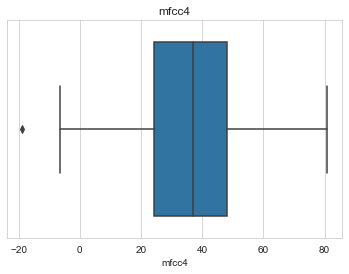

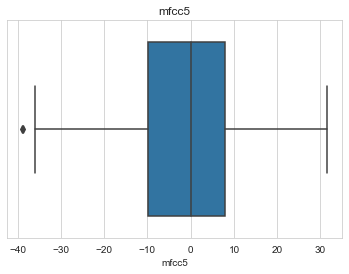

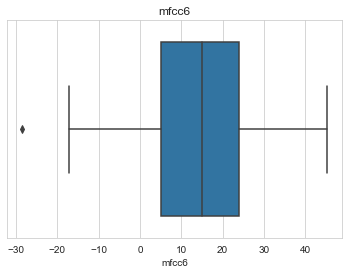

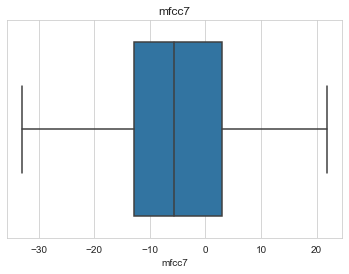

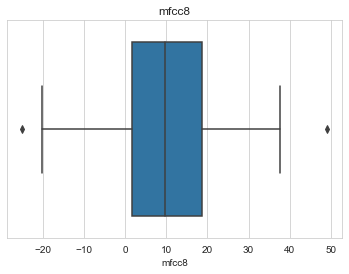

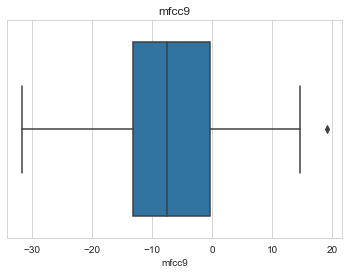

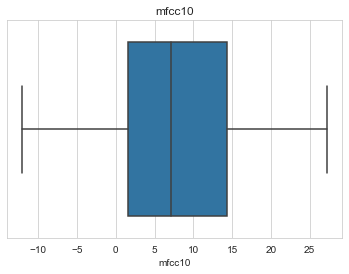

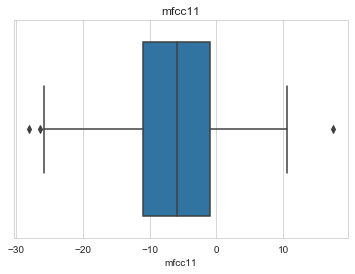

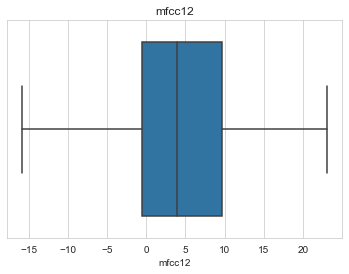

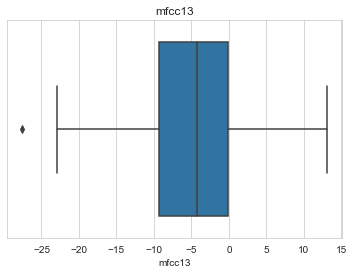

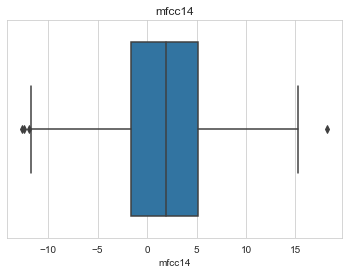

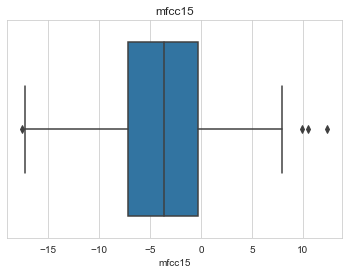

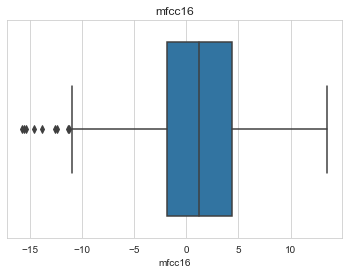

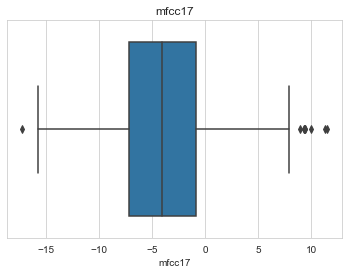

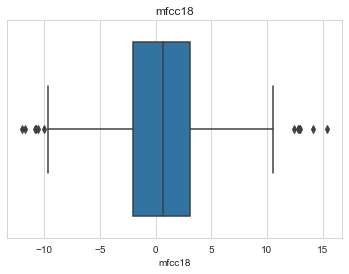

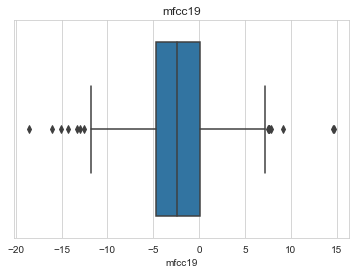

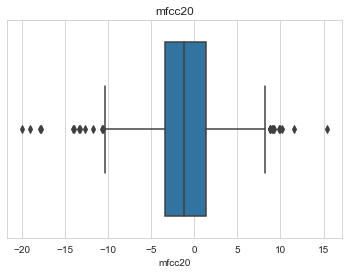

In [261]:
for name in df_simplified.drop(['filename','label'], axis=1).columns:
    plt.figure()
    sns.boxplot(df[name]).set_title(name);

However, one value was a prime candidate for removal  
Inspecting the values identified by the boxplot as extreme revealed that reggae.00086.wav is a corrupted file - listening to the track confirms this  

In [262]:
df_simplified[df_simplified['chroma_stft'] > 0.6]

,filename,chroma_stft,rmse,spectral_centroid,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
604,metal.00004.wav,0.634762,0.063475,3403.101905,0.192424,-107.103639,47.655542,-8.620057,38.400647,8.461632,...,11.062812,-2.530152,7.580201,-4.197063,7.077187,-6.621545,4.543788,-4.262345,4.291028,metal
612,metal.00012.wav,0.605022,0.114323,2803.257355,0.176913,-64.086452,74.522988,-45.975808,65.859227,-14.675553,...,17.917866,-10.794271,11.355470,-11.166484,8.714769,-8.964144,3.227732,-5.749997,2.419906,metal
613,metal.00013.wav,0.636205,0.086326,3047.823713,0.203604,-84.883416,64.645010,-36.333202,65.405247,-13.874631,...,19.178564,-10.615579,12.317148,-9.800135,10.557844,-9.914852,5.057372,-5.345447,3.806259,metal
886,reggae.00086.wav,0.663573,0.350981,4434.439444,0.260223,42.034587,37.395878,-7.958375,4.535131,8.993374,...,-0.390471,1.625972,2.915757,0.385918,-2.316738,-4.138039,-2.195434,-3.332318,-1.852860,reggae


Exporting the cleaner and simplified Dataframe to csv

In [263]:
df_simplified.to_csv('data_clean.csv')

## Cleaning Original Data

identifying the corrupted file's csv row index

In [264]:
corrupt_reggae_index = df_simplified[df_simplified['filename'] == "reggae.00086.wav"].index[0]

print("corrupted reggae file index:", corrupt_reggae_index)


corrupted reggae file index: 886


Deleting the corrupted image file and dataframe row  
Since there is only 1 image being removed, this should not impact any classifier greatly, the genres still have an approximately even number of images upon which to train and test

In [498]:
def remove_files_and_rows(reremove=False):
    if reremove:
        os.remove(f"test/reggae/reggae_86_spec.png")
        df_simplified.drop([corrupt_reggae_index], inplace=True)
    
remove_files_and_rows(reremove=False)

## Pytorch Convolutional Neural Network

A convolutional network identifies features based on proximity, and as such is most commonly used for images. Convolutional layers are partially connected layers that can be though of as fixed size filters that iterate over data, extracting values. Backpropogration trains these layers to extract features that best classify these features, such as certain lines and curves. Convolutional layers can be stacked to increase complexity. In the case of music, convolutional layers may be able to identify, for example, visual features that correspond to certain instruments, changes in pitch or tempo. The convolutional layers then feed into fully connected linear layers, which then are trained to classify based on the output of the convolutional layers.

Importing relevant packages for pytorch

In [266]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torch import nn, optim
import torch.nn.functional as F

import numpy as np
import os

import sys

from sklearn.metrics import confusion_matrix

import seaborn as sns
sns.set_style('whitegrid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Load the training and testing data using pytorch functions - having a train and test folder of images allows the use of pytorch's "ImageFolder" function

In [267]:
# Loading in training and testing data

data_path_train = f'./train'

train_dataset = torchvision.datasets.ImageFolder(
    root=data_path_train,
    transform=torchvision.transforms.ToTensor()
)

data_path_test = f'./test'

test_dataset = torchvision.datasets.ImageFolder(
    root= data_path_test,
    transform=torchvision.transforms.ToTensor()    
)

# Using a dataloader to split training data into batches
# demonstration purposes only - a seperate dataloader is used in the training loop

train_iter = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    num_workers=0,
    shuffle=True
)

The DataLoader has collated the data into batches

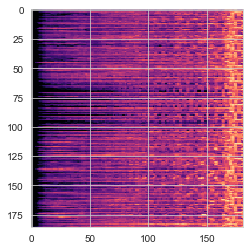

tensor(9)


In [268]:
for i, (X,y) in enumerate(train_iter):
    plt.imshow(X[0,:].transpose(0,2))
    plt.show()
    print(y[0])
    break

Making 2 more dataloader objects for the entire train and test datasets for when we check the accuracy on each one
The batch size will be the entire length of the dataset: 800 for the training set, 199 for the testing set (reggae track removed)


In [269]:
train_data_full = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=800,
    num_workers=0,
    shuffle=True
)

test_data_full = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=199,
    num_workers=0,
    shuffle=True
)

Getting some summary information about dataloader objects

In [270]:
# Getting a summary of the objects

print("Number of images and labels in Train:", len(train_dataset.imgs))
print("Number of images and labels in Test:", len(test_dataset.imgs))

# size of each X data
print("size of each X data point in Train:", train_dataset[0][0].size())
print("size of each X data point in Test:", test_dataset[0][0].size())

# Type of each y label
print("Type of y label in Train:", type(train_dataset[0][1]))
print("Type of y label in Test:", type(test_dataset[0][1]))

# Examples of each y label
print(train_dataset[0][1])
print(test_dataset[2][1])


# Info on train_iter
for i, (X,y) in enumerate(train_iter):
    print("Size of X data in each training batch:", X.size())
    print("Size of y labels in each training batch:", y.size())
    print("X training (data) type:", X.dtype)
    print("y training (labels type:", y.dtype)
    break

# info on train_data_full (which contains all the train data)
for i, (X,y) in enumerate(train_data_full):
    print("Size of X data in entire training batch:", X.size())
    print("Size of y labels in entire training batch:", y.size())
    print("X training (data) type:", X.dtype)
    print("y training (labels type:", y.dtype)
    break
    
# info on test_data_full (which contains all the test data)
for i, (X,y) in enumerate(test_data_full):
    print("Size of X data in entire test batch:", X.size())
    print("Size of y labels in entire test batch:", y.size())
    print("X testing (data) type:", X.dtype)
    print("y testing (labels type:", y.dtype)
    break


Number of images and labels in Train: 800
Number of images and labels in Test: 199
size of each X data point in Train: torch.Size([3, 181, 186])
size of each X data point in Test: torch.Size([3, 181, 186])
Type of y label in Train: <class 'int'>
Type of y label in Test: <class 'int'>
0
0
Size of X data in each training batch: torch.Size([64, 3, 181, 186])
Size of y labels in each training batch: torch.Size([64])
X training (data) type: torch.float32
y training (labels type: torch.int64
Size of X data in entire training batch: torch.Size([800, 3, 181, 186])
Size of y labels in entire training batch: torch.Size([800])
X training (data) type: torch.float32
y training (labels type: torch.int64
Size of X data in entire test batch: torch.Size([199, 3, 181, 186])
Size of y labels in entire test batch: torch.Size([199])
X testing (data) type: torch.float32
y testing (labels type: torch.int64


Crucially getting the image size, which will be crucial for determining parameters for the layers of the CNN

In [271]:
image_size = train_dataset[0][0].size()
image_size

torch.Size([3, 181, 186])

### Model Training Functions

Defining a function to test the model's accuracy

In [272]:
# This function is designed to take the entire train and test data, and feed it through the network
# it will check the model's prediction against the actual label and compute the accuracy
# it can also output the loss and predictions and labels if specified

def get_accuracy(model, data_to_test, criterion, return_loss = True, return_predictions=False):
    with torch.no_grad():
        # we do not want to train the model at this point, so using torch.no_grad()
        for i, (X_testing, y_testing) in enumerate(data_to_test):
            # get prediction
            predictions_testing = model(X_testing)
            if return_loss:
                # get loss if required
                test_loss = criterion(predictions_testing, y_testing)
            total_testing = 0
            correct_testing = 0
            for i in range(len(predictions_testing)):
                # argmax will return the index (and therefore the class) predicted
                if predictions_testing[i].argmax().item() == y_testing[i].item():
                    correct_testing += 1
                total_testing += 1
    
    # for the confusion matrix we need to keep the predictions and labels for the final iteration of testing
    if return_predictions:
        if return_loss:
            return predictions_testing, y_testing, test_loss, correct_testing/total_testing * 100
        return predictions_testing, y_testing, correct_testing/total_testing * 100
    
    # for the test loss we need to return the loss
    if return_loss:
        return test_loss, correct_testing/total_testing * 10
    
    # for the training dataset, we only need the accuracy, the loss has already been computed
    return correct_testing/total_testing * 100

Defining the function for the main training loop  
A learning rate of 0.002 was found to be the most effective for classifying the mel-spectograms

In [273]:
def train(model, learning_rate = 0.002, EPOCHS = 10, batch_size = 32, get_confusion_matrix = True,
          show_plots = True, print_accuracies = True, weight_decay = 0.0001, retrain=False):
    
    if retrain:
        # creating dataloader object, defining the criterion, the optimizer and creating lists with which to append values
        train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
        iteration_list, train_losses, test_losses, accuracy_list_training, accuracy_list_testing = [], [], [], [], []

        print('approx number of batches', len(train_dataset)*EPOCHS/batch_size)
        n = 0
        for epoch in range(EPOCHS):
            for i, (X_training, y_training) in enumerate(train_iter):
                y_training = y_training.type(torch.LongTensor)
                n += 1
                train_loss = 0
                test_loss = 0
                # getting outputs for each batch
                output = model(X_training)
                # computing cross_entropy_loss
                train_loss = criterion(output, y_training)
                # backpropogation
                train_loss.backward()
                optimizer.step()
                # reset gradients for the next batch
                optimizer.zero_grad()

                # get the accuracy for the entire training data
                accuracy_training = get_accuracy(model = model, data_to_test= train_data_full, criterion = criterion,
                                                            return_loss = False)
                # get the accuracy and predictions and y labels for the entire testing data
                predictions_testing, y_testing, test_loss, accuracy_testing = get_accuracy(model = model, data_to_test= test_data_full,
                                                                                criterion = criterion, return_predictions = True)

                # append iterations, accuracies and losses to a list for visualisation
                iteration_list.append(n)
                accuracy_list_training.append(accuracy_training)
                accuracy_list_testing.append(accuracy_testing)
                train_losses.append(train_loss.item())
                test_losses.append(test_loss.item())

                if print_accuracies:
                    print("Batch:", n, "accuracy_training:", accuracy_training, "accuracy_list_testing:", accuracy_testing)
                
        # once trained, save the model state
        torch.save(model.state_dict(), model.__class__.__name__)
        
        # picking results of model so as not to have to repeat training to see results
        
        with open(model.__class__.__name__ + "_" + "iteration_list.txt", "wb") as fp:   # Pickling
            pickle.dump(iteration_list, fp)        
        with open(model.__class__.__name__ + "_" + "accuracy_list_training.txt", "wb") as fp:   # Pickling
            pickle.dump(accuracy_list_training, fp)
        with open(model.__class__.__name__ + "_" + "accuracy_list_testing.txt", "wb") as fp:   # Pickling
            pickle.dump(accuracy_list_testing, fp)
        with open(model.__class__.__name__ + "_" + "train_losses.txt", "wb") as fp:   # Pickling
            pickle.dump(train_losses, fp)
        with open(model.__class__.__name__ + "_" + "test_losses.txt", "wb") as fp:   # Pickling
            pickle.dump(test_losses, fp)
        with open(model.__class__.__name__ + "_" + "y_testing.txt", "wb") as fp:   # Pickling
            pickle.dump(y_testing, fp)           
        with open(model.__class__.__name__ + "_" + "last_predictions.txt", "wb") as fp:   # Pickling
            pickle.dump(predictions_testing, fp)

    # if not retraining, open results of prior training using the pickle package        
    with open(model.__class__.__name__ + "_" + "iteration_list.txt", "rb") as fp:   #  Unpickling
        iteration_list = pickle.load(fp)
    with open(model.__class__.__name__ + "_" + "accuracy_list_training.txt", "rb") as fp:   # Unpickling
        accuracy_list_training = pickle.load(fp)
    with open(model.__class__.__name__ + "_" + "accuracy_list_testing.txt", "rb") as fp:   # Unpickling
        accuracy_list_testing = pickle.load(fp)
    with open(model.__class__.__name__ + "_" + "train_losses.txt", "rb") as fp:   # Unpickling
        train_losses = pickle.load(fp)
    with open(model.__class__.__name__ + "_" + "test_losses.txt", "rb") as fp:   # Unpickling
        test_losses = pickle.load(fp)
    with open(model.__class__.__name__ + "_" + "y_testing.txt", "rb") as fp:   # Unpickling
        y_testing = pickle.load(fp)        
    with open(model.__class__.__name__ + "_" + "last_predictions.txt", "rb") as fp:   # Unpickling
        predictions_testing = pickle.load(fp)
            
    if show_plots:
        # loss graph
        fig = plt.figure(figsize=(15,12))
        ax1 = fig.add_subplot(3,1,1)
        ax1.set_title('Training and Testing Losses over Batch Iterations')
        ax1.plot(iteration_list, train_losses, label = 'Training Losses')
        ax1.plot(iteration_list, test_losses, label = 'Testing Losses')
        plt.legend()
        
        # accuracy graph
        ax2 = fig.add_subplot(3,1,2)
        ax2.set_title('Train Accuracy and Test Accuracy over Batch Iterations - Training Data')
        ax2.plot(iteration_list, accuracy_list_training, label = 'Training Accuracy')
        ax2.plot(iteration_list, accuracy_list_testing, label = 'Testing Accuracy')
        plt.legend()

    
    # confusion matrix using the last set of predicitons and y labels
    if get_confusion_matrix:
        ax3 = fig.add_subplot(3,1,3)
        ax3.set_title('Confusion Matrix')
        conf_mat = confusion_matrix(y_testing.tolist(), predictions_testing.argmax(dim=1).tolist())
        sns.heatmap(conf_mat, annot=True,cmap='Blues', fmt='g')
        ax3.set_xticklabels(categories)
        ax3.set_yticklabels(categories)
        ax3.set_xlabel('Predicted')
        ax3.set_ylabel('True')

    # return the last value of the accuracy of the model on the testing data
    return(accuracy_list_testing[-1])

Defining a function to help calculate the values to use in the convolutional neural network

In [326]:
input_dim_1 = image_size[1]
input_dim_2 = image_size[2]

def get_linear_layer_input_dim(input_val, n_conv_layers, kernal_sizes, strides, paddings, pooling=[True, True, True]):
    val = input_val
    for i in range(n_conv_layers):    
        val = ((val - kernal_sizes[i] + 2*paddings[i])/strides[i]) + 1 # kernal iteration over data
        if pooling[i] == True:
            val = val/2 # pooling
    return(int(val))

linear_layer_input_dim_1 = get_linear_layer_input_dim(input_dim_1, n_conv_layers=3, kernal_sizes=[3,3,3], strides=[1,1,1], paddings=[0,0,0])
linear_layer_input_dim_2 = get_linear_layer_input_dim(input_dim_2, n_conv_layers=3, kernal_sizes=[3,3,3], strides=[1,1,1], paddings=[0,0,0])

print("dimension 1 of image:", input_dim_1)
print("dimension 2 of image:", input_dim_2)

print("linear layer input 1:", linear_layer_input_dim_1)
print("linear layer input 2:", linear_layer_input_dim_2)



dimension 1 of image: 181
dimension 2 of image: 186
linear layer input 1: 20
linear layer input 2: 21


### Designing CNN

Designing a convolutional neural network  
The model uses 3 convolutional layers, each with max pooling, and 4 linear layers, 2 of which use dropout, which is designed to prevent overfitting by preventing the network from becoming over reliant on specific connections  
The model uses an Adam optimiser, which is commonly used for image classification tasks, and cross entropy loss  
The Relu function is used for each linear layer to counteract the vanishing gradient problem.  

In [277]:
# Convolutional Neural Network

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.conv3 = nn.Conv2d(16, 10, 3)
        # linear layer input is the flattened output size of the convolutional layers
        self.fc1 = nn.Linear(10 * linear_layer_input_dim_1 * linear_layer_input_dim_2, 500)
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 50)
        self.fc4 = nn.Linear(50, 10)
        
        self.dropout = nn.Dropout(p=0.1)
        
    def forward(self, x):
        x = x.view(-1, 3, input_dim_1, input_dim_2)
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        # flattened output size of the convolutional layers
        x = x.view(-1, 10 * linear_layer_input_dim_1 * linear_layer_input_dim_2)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.softmax(x, dim=1)


The losses and accuraracies of the network on both the training and testing data is shown below. A confusion matrix is also diplayed. Note that the model state has been saved, along with the lists of accuracies and losses that have been used to make the graphs

23.618090452261306

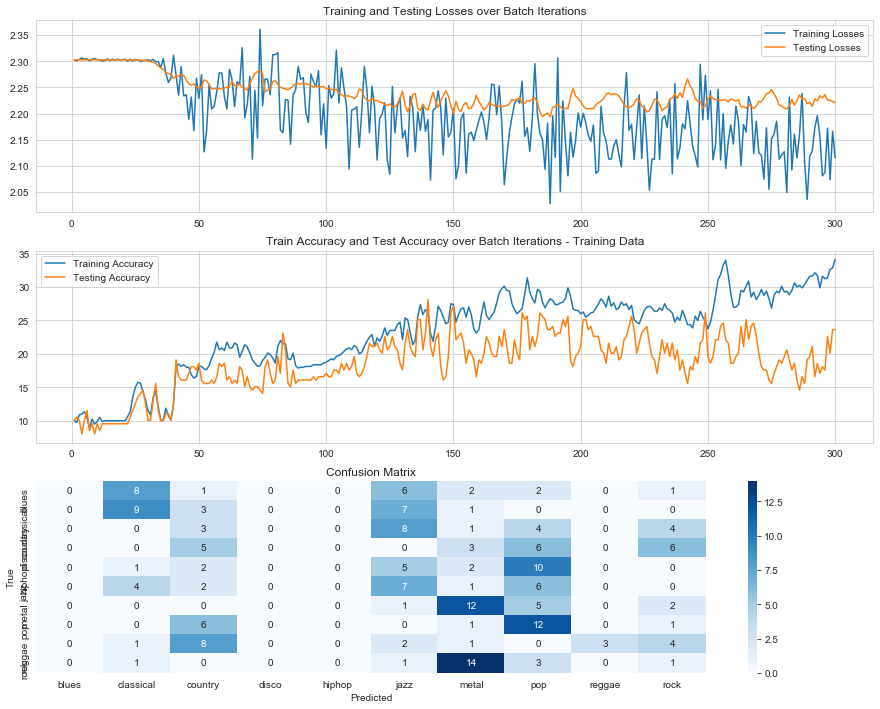

In [279]:
# training and evaluating the Convolutional Network

train(model = ConvNet(), EPOCHS=12, get_confusion_matrix=True, retrain=False) # use retrain=False to avoid rerunning the network

### Loading and Implementing on Individual Audio Files

Once trained, the model can be loaded since the state dictionary has been saved in the local directory  
Recall that the output can be considered as a probability of each class, since the softmax function has been used

In [320]:
model = ConvNet()
model.load_state_dict(torch.load(r"ConvNet"))
output = model(X[10])
output

tensor([[5.1904e-04, 7.6211e-02, 5.7712e-02, 3.2844e-04, 4.6651e-03, 7.0741e-01,
         1.8945e-07, 2.1280e-03, 1.4522e-01, 5.8109e-03]],
       grad_fn=<SoftmaxBackward>)

The output is an integer value which refers to the class

In [321]:
prediction = torch.argmax(output).item()
prediction

5

To convert the value to a class, create a dataframe which maps the output value to the corresponding category

In [322]:
predictions_df = pd.DataFrame(data={"categories":categories, "output":output[0].tolist()})

See the class as an output

In [323]:
print('Model predicted: ' + str(predictions_df.iloc[prediction][0]))

Model predicted: jazz


Visualising the output in term of probability

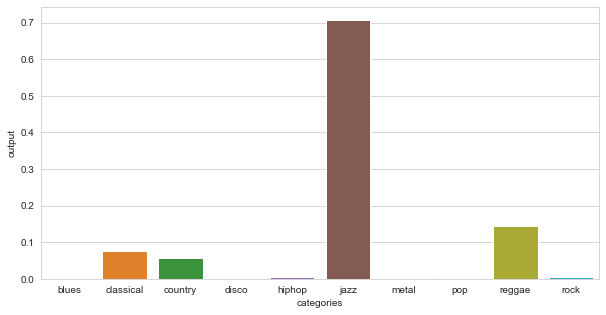

In [324]:
plt.figure(figsize=(10,5))
sns.barplot(x=predictions_df['categories'], y=predictions_df['output'])

In [ ]:
linear_layer_input_dim_1 = get_linear_layer_input_dim(input_dim_1, n_conv_layers=5, kernal_sizes=[11,3,3,3,3], strides=[4,1,1], paddings=[0,0,0])
linear_layer_input_dim_1 = get_linear_layer_input_dim(input_dim_2, n_conv_layers=5, kernal_sizes=[11,3,3,3,3], strides=[1,1,1], paddings=[0,0,0])

print("dimension 1 of image:", input_dim_1)
print("dimension 2 of image:", input_dim_2)

print("linear layer input 1:", linear_layer_input_dim_1)
print("linear layer input 2:", linear_layer_input_dim_2)

## Classifcation using Features: Feed Forward Neural Network using Keras

Instead of using a convolutional neural network

In [250]:
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#Keras
import keras

Using the feature set to train a feed forward linear neural network with the adam optimiser and cross entropy loss using keras. The Relu function is used for each linear layer to counteract the vanishing gradient problem.    

In [251]:
data = pd.read_csv('data_clean.csv') # importing the data
data = data.drop(['filename'],axis=1) # removing the filename column


genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)


scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))

model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train,
                    y_train,
                    validation_data = (X_test, y_test),
                    epochs=20,
                    batch_size=128)

Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - ETA: 1s - loss: 2.3271 - accuracy: 0.05 - 0s 381us/step - loss: 2.1938 - accuracy: 0.1900 - val_loss: 1.9462 - val_accuracy: 0.4150
Epoch 2/20
800/800 [==============================] - ETA: 0s - loss: 1.9447 - accuracy: 0.41 - 0s 25us/step - loss: 1.8315 - accuracy: 0.4350 - val_loss: 1.6171 - val_accuracy: 0.4550
Epoch 3/20
800/800 [==============================] - ETA: 0s - loss: 1.5358 - accuracy: 0.53 - 0s 26us/step - loss: 1.5323 - accuracy: 0.4863 - val_loss: 1.3415 - val_accuracy: 0.5300
Epoch 4/20
800/800 [==============================] - ETA: 0s - loss: 1.3850 - accuracy: 0.54 - 0s 26us/step - loss: 1.2720 - accuracy: 0.5763 - val_loss: 1.1202 - val_accuracy: 0.6500
Epoch 5/20
800/800 [==============================] - ETA: 0s - loss: 1.1252 - accuracy: 0.71 - 0s 25us/step - loss: 1.0429 - accuracy: 0.6675 - val_loss: 0.9386 - val_accuracy: 0.6950
Epoch 6/20
800/800 [========

The result is an exceptionally high testing accuracy of 89%, and a training accuracy of 95%.  
Given that human capability to correctly classify musical genres is about 70%, this is very strong result

In [60]:
test_loss, test_acc = model.evaluate(X_test,y_test)
print('test_acc: ',test_acc

200/200 [==============================] - ETA:  - 0s 45us/step


### Loading and Implementing on Individual Files

Saving the model to a json file in the local directory

In [86]:
from keras.models import model_from_json

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model.h5")

Loading the model

In [88]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")

Getting predictions using the model

In [89]:
predictions = loaded_model.predict(X_test)
print(predictions)
np.argmax(predictions[0])

2

Making a prediction, again using a dataframe that maps prediction values to the corresponding genres

In [91]:
predictions_df.iloc[np.argmax(predictions[0]),][0]

'country'